In [0]:
# Imports

import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn
import matplotlib.pyplot as plt

In [0]:
# Mount the drive to access the properly labeled patient information

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Read the curated .csv file into a pandas df


curated_results = pd.read_csv('/content/drive/My Drive/patient-test-results/curated-outputs/output-04-16-2020-1.csv')
curated_results





In [0]:
# Extract only the POSITIVE and NEGATIVE labeled data

curated_results_f1 = curated_results[curated_results.patient_mrn != 'UNMAPPED']

# TODO: Fix this filter, as it is not working
curated_results_f2 = curated_results_f1[curated_results.corona_test	!= 'REPEAT ']

curated_results_f2.head()

In [0]:
# Convert to a np array 


positive_sample_df =  curated_results_f2[curated_results_f2.corona_test == 'POSTIVE']
negative_sample_df = curated_results_f2[curated_results_f2.corona_test == 'NEGATIVE']

positive_sample_array = np.asarray(positive_sample_df)
negative_sample_array = np.asarray(negative_sample_df)


print("There are " , positive_sample_array.shape[0] , "positive samples in total")
print("There are " , negative_sample_array.shape[0] , "negative samples in total")



There are  6 positive samples in total
There are  36 negative samples in total


In [0]:
# Extract Medical History and convert to dictionary with numbers

med_history_array = curated_results_f2['medical_history']



#med_history_array = str(med_history_array)


## Parse the med_history_array and find unique comma seperated strings 

med_history_dict = {}
index = 0

for entry in med_history_array:
    entry = str(entry)
    history_list = entry.split(",")
    for hist in history_list:
      hist = hist.strip()
      hist_string = str(hist)
      if hist_string not in med_history_dict and 'None' not in hist and hist is not '' and 'nan' not in hist_string:    
        med_history_dict[hist_string] = index       
        index += 1


print("The dictionary with numbers: ", med_history_dict)


The dictionary with numbers:  {'Asthma or chronic lung disease': 0, 'Disease or conditions that make it harder to cough': 1, 'Diabetes with complications': 2, 'Congestive heart failure': 3}


In [0]:
# Assign the patients numerical history combination to an array

x_hist_text_train = []


for entry in curated_results_f2['medical_history']:
  entry = str(entry)
  num_seq = []
  if 'None' not in entry:
    for string in entry.split(","):
      if string is not '' and 'nan' not in string:
        num_seq.append(med_history_dict[string])


  final_array = np.asarray(num_seq) 

  x_hist_text_train.append(final_array)


x_hist_text_train = np.asarray(x_hist_text_train)
print('The shape of the x_text_train is ' , x_hist_text_train.shape)

x_hist_text_train = pad_sequences(x_hist_text_train)




The shape of the x_text_train is  (42,)


In [0]:
# Extract patient reported symptoms and convert to dictionary with numbers 


## Parse the med_history_array and find unique comma seperated strings 

symptom_dict = {}
index = 7

for entry in curated_results_f2['patient_reported_symptoms']:
    entry = str(entry)
    split_entry = re.findall('[A-Z][^A-Z]*', entry)
    for symptom in split_entry:
      symptom = symptom.strip().replace(',' , '')
      
      if symptom not in symptom_dict and 'None' not in symptom and 'nan' not in symptom:
        symptom_dict[symptom] = index
        index += 1

print("The dictionary with numbers: ", symptom_dict)


The dictionary with numbers:  {'Fever chills or sweating': 7, 'Shortness of breath': 8, 'Loss of taste': 9, 'Loss of smell': 10, 'New or worsening cough': 11, 'Sore throat': 12, 'Body aches': 13}


In [0]:
# Assign the patients numerical symptom combination to an array

x_symp_text_train =  [] #np.zeros(len(curated_results_f2['patient_reported_symptoms']))


for entry in curated_results_f2['patient_reported_symptoms']:
  entry = str(entry)
  num_seq = []
  
    
  split_entry = re.findall('[A-Z][^A-Z]*', entry)

  for symptom in split_entry:
      symptom = symptom.strip().replace(',' , '')

      if 'None' not in symptom and 'nan' not in symptom:
        num_seq.append(symptom_dict[symptom])

  final_array = np.asarray(num_seq) 

  x_symp_text_train.append(final_array)
    

x_symp_text_train = np.asarray(x_symp_text_train)
print('The shape of the x_text_train is ' , x_symp_text_train.shape)

x_symp_text_train = pad_sequences(x_symp_text_train)





The shape of the x_text_train is  (42,)


In [0]:
# Convert the smoking info into digits 

curated_results_f2.loc[curated_results_f2['smoker'] == 'no', 'smoker'] = 0.0
curated_results_f2.loc[curated_results_f2['smoker'] == 'yes', 'smoker'] = 1.0
smoker_array = curated_results_f2['smoker'].fillna(-1.0)


smoking_array = np.asarray(curated_results_f2['smoker'])
age_array = np.asarray(curated_results_f2['age'])


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [0]:
# Convert the y strings to digits

curated_results_f2.loc[curated_results_f2['corona_test'] == 'NEGATIVE', 'corona_test'] = 0.0
curated_results_f2.loc[curated_results_f2['corona_test'] == 'POSTIVE', 'corona_test'] = 1.0
#df.loc[df['corona_test'] == 'Not Tested', 'corona_test'] = -1

y_text_array = np.asarray(curated_results_f2['corona_test'])




/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [335]:

print('The shape of the y_text_train is ' , y_text_array.shape)


The shape of the y_text_train is  (42,)


In [336]:
# Combine the medical history input x, the symptom x ,
# the age x , and the smoking x into one final x array

input_x_array = np.hstack((x_hist_text_train , x_symp_text_train))

# Sort the sequences 
input_x_array.sort(axis=1)
# Conver to binary values
input_x_array[input_x_array != 0] = 1.0
input_x_array[input_x_array == 0] = 0.0

age_array_2d = np.expand_dims(age_array , axis =1)
smoker_array_2d = np.expand_dims(smoker_array , axis=1)

input_x_array = np.hstack((input_x_array , age_array_2d , smoker_array_2d))
# Use the input_x_array to feed into both deep learning and statistical models.

print(input_x_array)

[[ 0.  0.  0.  0.  0.  0.  0.  1. 32. -1.]
 [ 0.  0.  0.  0.  1.  1.  1.  1. 31. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. 21. -1.]
 [ 0.  0.  0.  1.  1.  1.  1.  1. 33. -1.]
 [ 0.  0.  0.  0.  0.  0.  1.  1. 27. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. 22. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 51.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1. 24.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1. 17.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1. 55.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1. 23.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1. 48.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. 25.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1. 47.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  1. 26.  0.]
 [ 0.  0.  0.  0.  1.  1.  1.  1. 17.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  1. 54.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. 21.  0.]
 [ 0.  0.  1.  1.  1.  1.  1.  1. 57.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. 22.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1. 24.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  1. 40.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. 30.  0.]
 [ 0.  0.  

In [0]:
# Split into train, validate, and test

## Question: How should we split the data-sets?


def split_data(input_x_array , y_text_array , test_size=0.2 , random_state=1 ):
  X_train, X_test, y_train, y_test = train_test_split(input_x_array, y_text_array, test_size=0.2, random_state=1) # What shouldd the X be?

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1) # 0.5 x 0.8 = 0.4

  y_train = y_train.astype('int')
  y_test = y_test.astype('int')
  y_val = y_val.astype('int')

  return X_train, X_val, y_train, y_val , X_test , y_test



In [366]:
# Random Forest Classifer

def rf_model(x_train , y_train , x_val , y_val , x_test , y_test):
  model = rf()
  model.fit(x_train , y_train)
  
  # Evaluate the model


  
  score = model.score(x_val , y_val)
  predictions = model.predict(x_val)
  return score , predictions


# Perfrom ten times and average the results


num_times = 50
total_acc = np.zeros(num_times)

predictions_rf = []

for i in range(0, num_times):
  X_train, X_val, y_train, y_val , X_test , y_test = split_data(input_x_array , y_text_array)
  acc , predictions_rf = rf_model(X_train , y_train, X_val , y_val , X_test , y_test)
  total_acc[i] = acc

mean = np.mean(total_acc)

print('The mean accuracy after ' , num_times , ' times is '  , mean)





The mean accuracy after  50  times is  0.8211764705882351


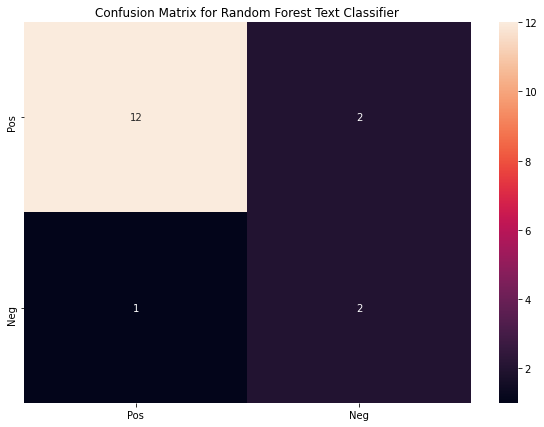

In [374]:
# RF Heatmap 


CM = confusion_matrix(y_val, predictions_rf)



df_cm = pd.DataFrame(CM, index = ["Pos" , "Neg"],
                  columns = ["Pos" , "Neg"])
plt.figure(figsize = (10,7))
plt.xlabel('Predicted')
plt.ylabel('True Values')
plt.title('Confusion Matrix for Random Forest Text Classifier')
seaborn.heatmap(df_cm, annot=True)


In [372]:
#  SVM 
def svm_model(x_train , y_train , x_test , y_test , kernel , C):
  y_train = y_train.astype('int')
  y_test = y_test.astype('int')
  model = SVC(C=C ,  kernel=kernel)
  model.fit(x_train , y_train)
  
  predictions_svm = model.predict(x_test)
  # Evaluate the model
  score = score = model.score(x_test , y_test)
  return score , predictions_svm


num_times = 50
total_acc = np.zeros(num_times)
predictions_svm = []
for i in range(0, num_times):
  X_train, X_val, y_train, y_val , X_test , y_test = split_data(input_x_array , y_text_array)
  acc , predictions_svm = svm_model(X_train , y_train, X_val , y_val , kernel='rbf' , C=1.0)

  total_acc[i] = acc

mean = np.mean(total_acc)

print('The mean accuracy after ' , num_times , ' times is '  , mean)


The mean accuracy after  50  times is  0.8235294117647056


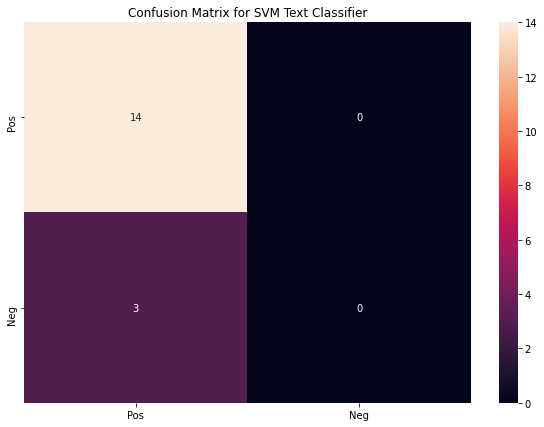

In [376]:
# SVM Heatmap 


CM = confusion_matrix(y_val, predictions_svm)



df_cm = pd.DataFrame(CM, index = ["Pos" , "Neg"],
                  columns = ["Pos" , "Neg"])
plt.figure(figsize = (10,7))
plt.xlabel('Predicted')
plt.ylabel('True Values')
plt.title('Confusion Matrix for SVM Text Classifier')
seaborn.heatmap(df_cm, annot=True)